In [34]:
!pip install scikit-plot
!pip install kaggle
!pip install kagglehub --upgrade


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/68.0 kB ? eta -:--:--
   ------------------------------------ --- 61.4/68.0 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 68.0/68.0 kB 1.2 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.2.1
    Uninstalling kagglehub-0.2.1:
      Successfully uninstalled kagglehub-0.2.1


# REGRESSION MODEL

#### Import Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import LinearRegression
import scikitplot as skplt
from scipy.stats import skew
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#### Import Data - Public Funding and Donations to UK Political Parties (Regression)

https://www.kaggle.com/datasets/thedevastator/donations-accepted-by-political-parties-in-the-u



In [2]:
# Path to your CSV file
csv_path = r"C:\Users\MSI\OneDrive\1. BiG_dAtA_Master_Degree\thesis\Code\Data\Regression\Donations accepted by political parties.csv"

# Load the CSV
data = pd.read_csv(csv_path)

C:\Users\MSI\AppData\Local\Temp\ipykernel_11104\367354798.py:5: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(csv_path)


In [3]:
print("\nColumn Names:")
print(data.columns)


Column Names:
Index(['index', 'ECRef', 'RegulatedEntityName', 'RegulatedEntityType', 'Value',
       'AcceptedDate', 'AccountingUnitName', 'DonorName',
       'AccountingUnitsAsCentralParty', 'IsSponsorship', 'DonorStatus',
       'RegulatedDoneeType', 'CompanyRegistrationNumber', 'Postcode',
       'DonationType', 'NatureOfDonation', 'PurposeOfVisit', 'DonationAction',
       'ReceivedDate', 'ReportedDate', 'IsReportedPrePoll',
       'ReportingPeriodName', 'IsBequest', 'IsAggregation',
       'RegulatedEntityId', 'AccountingUnitId', 'DonorId', 'CampaigningName',
       'RegisterName', 'IsIrishSource'],
      dtype='object')


In [4]:
data.head()

,index,ECRef,RegulatedEntityName,RegulatedEntityType,Value,AcceptedDate,AccountingUnitName,DonorName,AccountingUnitsAsCentralParty,IsSponsorship,...,IsReportedPrePoll,ReportingPeriodName,IsBequest,IsAggregation,RegulatedEntityId,AccountingUnitId,DonorId,CampaigningName,RegisterName,IsIrishSource
0,0,NC0408174,Mr Andy Street,Regulated Donee,"£1,876.56",02/09/2019,NaN,Conservative and Unionist Party,False,False,...,NaN,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False
1,1,NC0408173,Mr Andy Street,Regulated Donee,"£2,700.00",02/09/2019,NaN,Conservative and Unionist Party,False,False,...,NaN,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False
2,2,NC0408177,Mr Andy Street,Regulated Donee,"£4,852.58",30/08/2019,NaN,Conservative and Unionist Party,False,False,...,NaN,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False
3,3,NC0408176,Mr Andy Street,Regulated Donee,"£2,500.00",30/08/2019,NaN,Conservative and Unionist Party,False,False,...,NaN,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False
4,4,NC0408170,Mr Andy Street,Regulated Donee,"£4,524.05",29/08/2019,NaN,Conservative and Unionist Party,False,False,...,NaN,September 2019,False,False,8015,NaN,86310.0,NaN,Great Britain,False


### EXPLORATION AND CLEANING DATA

###### Summary of Excluded Columns
- ###### Identifiers: index, ECRef, RegulatedEntityId, AccountingUnitId, DonorId – No predictive value, only unique identifiers.
- ###### High Missing Rate: RegulatedDoneeType (~89%), CompanyRegistrationNumber (~82%), NatureOfDonation (~85%), PurposeOfVisit (~96%), DonationAction (~99.6%), CampaigningName (~99.99%) – Too many missing values, unusable.
- ###### Redundant: AccountingUnitName (~13%, redundant with RegulatedEntityName), ReceivedDate (~4%, similar to AcceptedDate), ReportingPeriodName (redundant with AcceptedDate), Reported ReportedDate (administrative) – Duplicated or irrelevant information.
- ###### High Cardinality: DonorName (unique names), RegulatedEntityName (1,384 values), Postcode (4,559 values) – Generate excessive dummy columns, increasing complexity and risk of overfitting.
- ###### Low Variability: IsReportedPrePoll (only False), RegisterName (~90% Great Britain) – Do not provide predictive information.

In [6]:
# Exploration and Data Cleaning
# Objective: Understand dataset structure, types, and missing values.
print("1. Data Exploration and Cleaning")
print("\nDataset Info:")
print(data.info())
print("\nMissing Values per Column:")
print(data.isnull().sum())

1. Data Exploration and Cleaning

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65278 entries, 0 to 65277
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          65278 non-null  int64  
 1   ECRef                          65278 non-null  object 
 2   RegulatedEntityName            65278 non-null  object 
 3   RegulatedEntityType            65278 non-null  object 
 4   Value                          65278 non-null  object 
 5   AcceptedDate                   64265 non-null  object 
 6   AccountingUnitName             56957 non-null  object 
 7   DonorName                      65193 non-null  object 
 8   AccountingUnitsAsCentralParty  65278 non-null  bool   
 9   IsSponsorship                  65278 non-null  bool   
 10  DonorStatus                    65220 non-null  object 
 11  RegulatedDoneeType             7090 non-null   object 
 12

In [7]:
# Select definitive columns
selected_columns = [
    'Value', 'RegulatedEntityType', 'DonorStatus', 'DonationType', 
    'AcceptedDate', 'IsSponsorship', 'IsBequest', 'IsAggregation', 
    'AccountingUnitsAsCentralParty', 'IsIrishSource'
    ]
data_selected = data[selected_columns].copy()  # Create independent copy
print(data_selected)

             Value    RegulatedEntityType                 DonorStatus  \
0        £1,876.56        Regulated Donee  Registered Political Party   
1        £2,700.00        Regulated Donee  Registered Political Party   
2        £4,852.58        Regulated Donee  Registered Political Party   
3        £2,500.00        Regulated Donee  Registered Political Party   
4        £4,524.05        Regulated Donee  Registered Political Party   
...            ...                    ...                         ...   
65273   £10,000.00  Permitted Participant                     Company   
65274  £100,000.00  Permitted Participant                  Individual   
65275   £40,000.00  Permitted Participant                  Individual   
65276   £50,000.00        Political Party                  Individual   
65277   £15,000.00        Political Party                  Individual   

      DonationType AcceptedDate  IsSponsorship  IsBequest  IsAggregation  \
0         Non Cash   02/09/2019          False 

In [9]:
#Clean and convert 'Value'
print("\nDescriptive Statistics for Value (before cleaning):")
print(data['Value'].describe())

data_selected.loc[:, 'Value'] = data_selected['Value'].replace('[\£,]', '', regex=True)
data_selected.loc[:, 'Value'] = pd.to_numeric(data_selected['Value'], errors='coerce')
data_selected['Value'] = data_selected['Value'].astype(float)

print("NEW Dataset Info:")
print(data_selected.info())


Descriptive Statistics for Value (before cleaning):
count         65278
unique        11253
top       £2,000.00
freq           5276
Name: Value, dtype: object
NEW Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65278 entries, 0 to 65277
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Value                          65278 non-null  float64
 1   RegulatedEntityType            65278 non-null  object 
 2   DonorStatus                    65220 non-null  object 
 3   DonationType                   65278 non-null  object 
 4   AcceptedDate                   64265 non-null  object 
 5   IsSponsorship                  65278 non-null  bool   
 6   IsBequest                      65278 non-null  bool   
 7   IsAggregation                  65278 non-null  bool   
 8   AccountingUnitsAsCentralParty  65278 non-null  bool   
 9   IsIrishSource                  64557 non-null  o

In [10]:
#Handle missing values with MODA
cat_columns = ['RegulatedEntityType', 'DonorStatus', 'DonationType', 'IsIrishSource']
imputer_cat = SimpleImputer(strategy='most_frequent') # Imputed by MODA

data_selected.loc[:, cat_columns] = imputer_cat.fit_transform(
    data_selected[cat_columns])

# Drop rows with missing AcceptedDate
data_selected = data_selected.dropna(subset=['AcceptedDate'])

# Verification
print("Missing values after imputation:")
print(data_selected.isna().sum())

Missing values after imputation:
Value                            0
RegulatedEntityType              0
DonorStatus                      0
DonationType                     0
AcceptedDate                     0
IsSponsorship                    0
IsBequest                        0
IsAggregation                    0
AccountingUnitsAsCentralParty    0
IsIrishSource                    0
dtype: int64


In [11]:
#Feature EngineerAcceptedDate
# Adapted function to convert text or datetime to datetime
def convert_to_datetime(value):
    if pd.isna(value):
        return pd.NaT
    if isinstance(value, pd.Timestamp) or isinstance(value, datetime):  # Preserve Timestamps or datetime
        return pd.to_datetime(value)
    if isinstance(value, str):  # Handle text dates
        try:
            # Try dd/mm/yyyy or d/m/yyyy (both handled by %d/%m/%Y)
            return pd.to_datetime(value, format='%d/%m/%Y', errors='coerce')
        except:
            return pd.NaT
    return pd.NaT

# Apply conversion
# Observation: Convert text dates to datetime, preserve Timestamps. Keep NaT for nulls/invalid dates.
data_selected.loc[:, 'AcceptedDate'] = data_selected['AcceptedDate'].apply(convert_to_datetime)
#Verify
print("NaT dates (invalid or null):", data_selected['AcceptedDate'].isna().sum())

NaT dates (invalid or null): 0


In [12]:
# Extract Year
# Convert AcceptedDate to datetime64[ns]
data_selected['AcceptedDate'] = pd.to_datetime(data_selected['AcceptedDate'], errors='coerce', dayfirst=True)
# Extract year and drop the original column
data_selected['Year'] = data_selected['AcceptedDate'].dt.year
data_selected.drop(columns='AcceptedDate', inplace=True)

# Verification
print("\nUnique values of Year (without NaN)):", sorted(data_selected['Year'].dropna().unique()))


Unique values of Year (without NaN)): [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


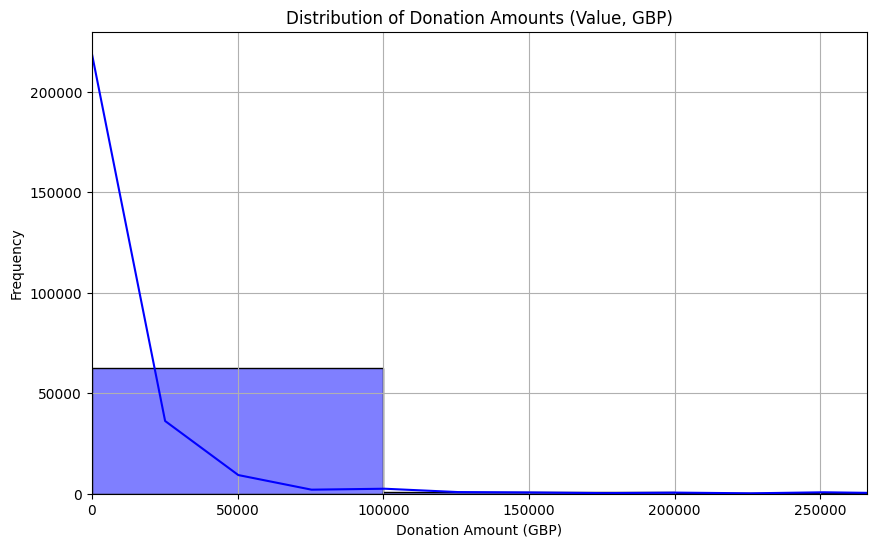

Skewness: 19.851462185463905


In [15]:
# Plot Value distribution before transformation
# Objective: Visualize long-tail distribution.
plt.figure(figsize=(10, 6))
sns.histplot(data_selected['Value'].dropna(), bins=50, kde=True, color='blue')
plt.title('Distribution of Donation Amounts (Value, GBP)')
plt.xlabel('Donation Amount (GBP)')
plt.ylabel('Frequency')
plt.xlim(0, data_selected['Value'].quantile(0.99))
plt.grid(True)
plt.show()
print("Skewness:", skew(data_selected['Value'].dropna()))

In [17]:
# Transform Value, apply log1p to reduce skewness.
if (data_selected['Value'] < 0).any():
    print("Warning: Negative values in Value. Converting to NaN.")
    data_selected.loc[data_selected['Value'] < 0, 'Value'] = np.nan
data_selected['Value'] = np.log1p(data_selected['Value'])

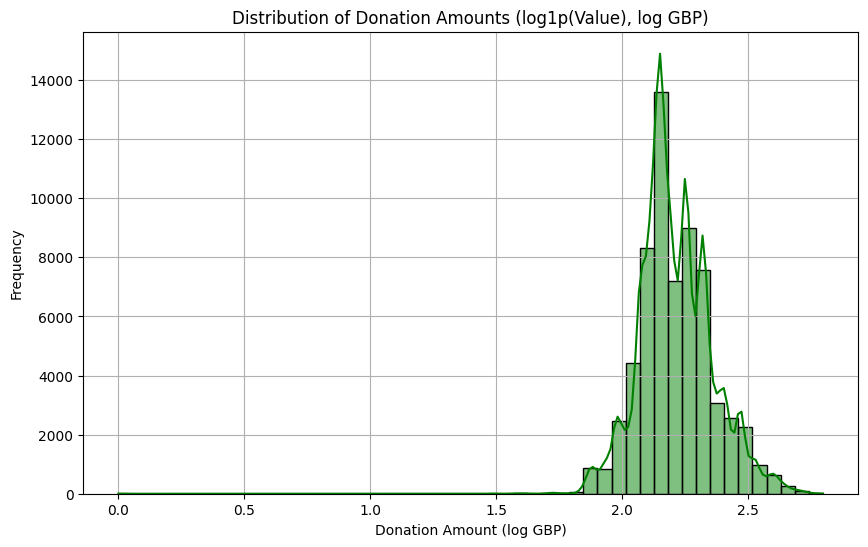

Skewness: 0.1294067333395532


In [18]:
# Plot Value distribution after transformation
# Objective: Visualize symmetric distribution.
plt.figure(figsize=(10, 6))
sns.histplot(data_selected['Value'].dropna(), bins=50, kde=True, color='green')
plt.title('Distribution of Donation Amounts (log1p(Value), log GBP)')
plt.xlabel('Donation Amount (log GBP)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
print("Skewness:", skew(data_selected['Value'].dropna()))

In [22]:
# One-hot encode categorical variables
data_encoded = pd.get_dummies(data_selected, columns=cat_columns, drop_first=True)
print(data_encoded.head())

      Value  IsSponsorship  IsBequest  IsAggregation  \
0  2.144495          False      False          False   
1  2.186206          False      False          False   
2  2.249972          False      False          False   
3  2.177526          False      False          False   
4  2.242557          False      False          False   

   AccountingUnitsAsCentralParty  Year  RegulatedEntityType_Political Party  \
0                          False  2019                                False   
1                          False  2019                                False   
2                          False  2019                                False   
3                          False  2019                                False   
4                          False  2019                                False   

   RegulatedEntityType_Regulated Donee  RegulatedEntityType_Third Party  \
0                                 True                            False   
1                                 True

In [23]:
# Define features and target
X = data_encoded.drop('Value', axis=1)
y = data_encoded['Value']

In [ ]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\nNormalization Verification:")
print("Mean of scaled features:", X_scaled.mean(axis=0).round(4))
print("Std of scaled features:", X_scaled.std(axis=0).round(4))


Normalization Verification:
Mean of scaled features: [ 0.  0.  0. -0. -0.  0.  0. -0. -0. -0.  0.  0. -0. -0. -0.  0.  0.  0.
  0. -0.  0.  0.  0.  0.  0.]
Std of scaled features: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]


In [39]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
print("Train X shape:", X_train.shape)
print("Test X shape:", X_test.shape)
print("Train y shape:", y_train.shape)
print("Test y shape:", y_test.shape)

Train X shape: (44985, 25)
Test X shape: (19280, 25)
Train y shape: (44985,)
Test y shape: (19280,)


In [ ]:
# Random Forest Model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [44]:
# Function to calculate Adjusted R² using len()
def adjusted_r2(r2, y_test, X_test):
    n = len(y_test)  # Number of observations
    p = len(X_test[0])  # Number of predictors
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)


In [47]:
# Random Forest Metrics
# Mean Squared Error (MSE): 
rf_mse = mean_squared_error(y_test, rf_pred)
# Root Mean Squared Error (RMSE): 
rf_rmse = np.sqrt(rf_mse)
# Root Mean Squared Logarithmic Error (RMSLE):
rf_rmsle = rf_rmse  # RMSLE = RMSE since y is log-transformed
# Mean Absolute Error (MAE):
rf_mae = mean_absolute_error(y_test, rf_pred)
# R-squared (R²):
rf_r2 = r2_score(y_test, rf_pred)  # Aligned with kulkarni-vishwanath
# Adjusted R-squared (R²_adj): 
rf_r2_adj = adjusted_r2(rf_r2, y_test, X_test)
# Mean Absolute Percentage Error (MAPE):
rf_mape = np.nanmean(np.abs((y_test - rf_pred) / np.where(y_test != 0, y_test, np.nan))) * 100

In [48]:
print("\nRandom Forest Metrics:")
print(f"Mean Squared Error (MSE): {rf_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.4f}")
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rf_rmsle:.4f}")
print(f"Mean Absolute Error (MAE): {rf_mae:.4f}")
print(f"R-squared (R²): {rf_r2:.4f}")
print(f"Adjusted R-squared (R²_adj): {rf_r2_adj:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {rf_mape:.4f}")


Random Forest Metrics:
Mean Squared Error (MSE): 0.0124
Root Mean Squared Error (RMSE): 0.1112
Root Mean Squared Logarithmic Error (RMSLE): 0.1112
Mean Absolute Error (MAE): 0.0850
R-squared (R²): 0.4055
Adjusted R-squared (R²_adj): 0.4047
Mean Absolute Percentage Error (MAPE): 3.7890


IMPORT DATA - Non-Profit Funding in the EU (Classification)

https://www.kaggle.com/datasets/sarmitamajumdar/finding-donors-for-a-charity/data